In [2]:
"""
Assignment 1 - music genre classification
"""

import sys
import pdb
sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from tempfile import TemporaryFile
import os
import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier
from utils import learn_curve, val_curve
from keras.models import Sequential
from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, Callback



In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
file_path = "data/gtzan_music_genre/"
print(os.listdir(f'{file_path}/'))

['features_30_sec.csv']


In [4]:
# sound, sample_rate = librosa.load(f'{file_path}/genres_original/classical/classical.00005.wav')
# print(sound[:5])
# print(sample_rate)

# plt.figure(figsize=(16, 6))
# librosa.display.waveshow(y=sound, sr=sample_rate, color="darkred")
# plt.title("Waveform of classical.00005.wav", fontsize=12)  
# plt.show()

In [5]:
# sound_rock, sample_rate_rock = librosa.load(f'{file_path}/genres_original/rock/rock.00017.wav')
# print(sound_rock[:5])
# print(sample_rate_rock)

# plt.figure(figsize = (16,6))
# librosa.display.waveshow(y = sound_rock, sr = sample_rate_rock, color = 'darkred')
# plt.title('Wavefrom of rock.00017.wav')

In [6]:
# n_fft = 2048 # FFT window size
# hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# # Short-time Fourier transform (STFT)
# D = np.abs(librosa.stft(sound_rock, n_fft = n_fft, hop_length = hop_length))

# print('Shape of D object:', np.shape(D))

In [7]:
# pd.set_option('display.max_columns', 60)
train_df = pd.read_csv(f'{file_path}/features_30_sec.csv')
train_df.head()
print(train_df.shape)
print(train_df.info())

(1000, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean  

In [8]:
# import seaborn as sns
# label_tempo_df= train_df[['label', 'tempo']]

# f, ax = plt.subplots(figsize = (16,9))
# sns.boxplot(x = 'label', y = 'tempo', data = label_tempo_df, palette = 'rocket' )

# plt.title('BPM Boxplot for Genres', fontsize = 15)
# plt.xticks(fontsize = 15)
# plt.yticks(fontsize = 15)
# plt.xlabel('Genre', fontsize = 20)
# plt.ylabel('BPM', fontsize = 20)
# plt.show()

In [9]:
# Preprocessing
train_df = train_df.drop(['filename', 'length'], axis = 1)
y = train_df['label']
X = train_df.drop('label', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# cols = X.columns
# min_max_scaler = preprocessing.MinMaxScaler()
# np_scaled = min_max_scaler.fit_transform(X)
# X = pd.DataFrame(np_scaled, columns = cols)

# from sklearn.decomposition import PCA

# pca = PCA(n_components = 2)
# principalComponents = pca.fit_transform(X)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# finalDf = pd.concat([principalDf, y], axis = 1)
# print('variance ratio : ', pca.explained_variance_ratio_)
# print('sum : ', sum(pca.explained_variance_ratio_))

In [11]:
# pca = PCA(whiten = True).fit(X)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()

# Models

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE

In [13]:
# data = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
# data.head()

In [14]:
# More preprocessing
scale = MinMaxScaler()
scaled_data = scale.fit_transform(x_train)
x_train_sc = pd.DataFrame(scaled_data, columns = x_train.columns).values
scaled_data = scale.fit_transform(x_test)
x_test_sc = pd.DataFrame(scaled_data, columns = x_test.columns).values

In [15]:
# KNN

# Curve based on value of K - Validation curve
val_knn = False
if val_knn:
    k_accs = {}
    for k_val in range(1,24):
        knn = KNeighborsClassifier(n_neighbors=k_val)
        knn.fit(x_train_sc, y_train)
        y_pred = knn.predict(x_test_sc)
        k_accs[k_val] = accuracy_score(y_test, y_pred)
        print("K val: {}   acc: {}".format(k_val, k_accs[k_val]))
    val_curve(list(k_accs.keys()), list(k_accs.values()), "knn_music", "value for K")

learn_knn = False
if learn_knn:
    # Shuffle the data without replacement - Learning curve
    x_accs = {}
    train_accs = {}
    for x_perc in range(1,11):
        x_perc = x_perc / 10
        # shuffled_data = shuffle(x_train, random_state=RANDOM_SEED)
        x_percent_index = int(x_perc * len(x_train_sc))
        # Take the first X% of the shuffled data
        first_x_percent = x_train_sc[:x_percent_index]
        y_train_iter = y_train[:x_percent_index]
        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(first_x_percent, y_train_iter)
        y_pred = knn.predict(x_test_sc)
        x_accs[x_perc*10] = accuracy_score(y_test, y_pred)
        y_pred_train = knn.predict(x_train_sc)
        train_accs[x_perc*10] = accuracy_score(y_train, y_pred_train)
        print("K val: {}   acc: {}".format(int(x_perc*10), x_accs[x_perc*10]))
    learn_curve(list(x_accs.keys()), list(train_accs.values()), list(x_accs.values()), "knn_music")

In [16]:
# DT - hyperparameter tuning - Validation curve
dt_max_depth = False

if dt_max_depth:
    # Max Depth
    # Define the range of values for the hyperparameter (e.g., max_depth)
    param_range = np.arange(1, 31)

    # Create a decision tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=42)

    # Generate training and test scores using validation_curve
    train_scores, test_scores = validation_curve(
        dt_classifier, x_train, y_train, param_name="max_depth", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
    )

    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve for Decision Tree - Max Depth")
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    # Plot the mean training scores
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
    # Fill the area around the mean training scores
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
    # Plot the mean test scores
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
    # Fill the area around the mean test scores
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="navy")
    plt.legend(loc="best")
    plt.savefig("pngs/validation_curve_dt_max_depth_music.png", dpi=300)
    plt.close()

In [17]:
# Min samples to split
# Define the range of values for the hyperparameter (e.g., max_depth)
dt_min_split = False

if dt_min_split:
    param_range = np.arange(0, 15)

    # Create a decision tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=12)

    # Generate training and test scores using validation_curve
    train_scores, test_scores = validation_curve(
        dt_classifier, x_train_sc, y_train, param_name="min_samples_split", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
    )

    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print(test_scores_mean)

    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve for Decision Tree - Min Samples Split")
    plt.xlabel("Min Samples Split")
    plt.ylabel("Accuracy")
    # Plot the mean training scores
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
    # Fill the area around the mean training scores
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
    # Plot the mean test scores
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
    # Fill the area around the mean test scores
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="navy")
    plt.legend(loc="best")
    plt.savefig("pngs/validation_curve_dt_min_samples_split_music.png", dpi=300)
    # plt.savefig("pngs/validation_curve_dt_min_samples_leaf.png", dpi=300)
    plt.close()


In [18]:
# Criterion
crit = False

if crit:
    # Define the range of values for the hyperparameter (e.g., max_depth)
    param_range = ['gini', 'entropy']

    # Create a decision tree classifier
    dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=13)

    # Generate training and test scores using validation_curve
    train_scores, test_scores = validation_curve(
        dt_classifier, x_train, y_train, param_name="criterion", param_range=param_range,
        cv=5, scoring="accuracy", n_jobs=-1
    )

    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    print(test_scores_mean)
    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve for Decision Tree - Criterion")
    plt.xlabel("Criterion")
    plt.ylabel("Accuracy")

    # Plot the mean training scores
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
    # Fill the area around the mean training scores
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
    # Plot the mean test scores
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
    # Fill the area around the mean test scores
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="navy")
    plt.xticks(['gini', 'entropy'])
    plt.legend(loc="best")
    plt.savefig("pngs/validation_curve_dt_criterion_music.png", dpi=300)
    plt.close()

In [19]:
# DT - Amount of data - Learning curve
l_curve = False

if l_curve:
    x_accs = {}
    train_accs = {}
    for x_perc in range(1,11):
        x_perc = x_perc / 10
        print(x_perc)
        x_percent_index = int(x_perc * len(x_train))
        # Take the first X% of the shuffled data
        first_x_percent = x_train[:x_percent_index]
        y_train_iter = y_train[:x_percent_index]
        dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42)
        dec_tree.fit(first_x_percent, y_train_iter)
        y_pred = dec_tree.predict(x_test)
        x_accs[x_perc*10] = accuracy_score(y_test, y_pred)
        y_pred_train = dec_tree.predict(x_train)
        train_accs[x_perc*10] = accuracy_score(y_train, y_pred_train)
        print("Perc val: {}   acc: {}".format(int(x_perc*10), x_accs[x_perc*10]))
    learn_curve(list(x_accs.keys()), list(train_accs.values()), list(x_accs.values()), "dec_tree_music")


In [20]:
# DT - epochs - Learning curve
dt_epoch = False

if dt_epoch:
    # Number of epochs
    epochs = 5

    # Initialize the decision tree classifier
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=12, random_state=42)
    x_accs = {}
    train_accs = {}
    # Loop through epochs
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}:")

        # Train the decision tree on the training set
        clf.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = clf.predict(x_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        x_accs[epoch+1] = accuracy_score(y_test, y_pred)
        y_pred_train = dec_tree.predict(x_train)
        train_accs[epoch+1] = accuracy_score(y_train, y_pred_train)
        print("Perc val: {}   acc: {}".format(epoch+1, x_accs[epoch+1]))
    learn_curve(list(x_accs.keys()), list(train_accs.values()), list(x_accs.values()), "dec_tree_epochs_music", x_axis="Epochs")



In [21]:
# Boosting Tree - Hyperparameter tuning - Validation curve
boost_gscv = False

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

if boost_gscv:
    # Create XGBoost classifier
    xgb_classifier = XGBClassifier()

    # Define hyperparameters to tune
    param_grid = {
        'n_estimators': [15, 50, 150, 200, 250],
        'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'min_child_weight': [1, 5, 10, 15],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    }

    param_grid = {
        'n_estimators': [200],
        'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'min_child_weight': [1, 5, 10, 15],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_classifier,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    # Perform grid search
    grid_search.fit(x_train_sc, y_encoded)

    # Display the best hyperparameters and corresponding accuracy
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

    print(grid_search.cv_results_)



In [22]:
# Boosting tree - Validation curve - max depth
bt_md = False

if bt_md:
    xgb_classifier = XGBClassifier(learning_rate=0.3, min_child_weight=1, max_depth = 7, subsample=0.9, colsample_bytree=1.0)
    
    param_grid = {
        "n_estimators": [10, 50, 100, 150, 200, 250]
    }

    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_classifier,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    # Perform grid search
    grid_search.fit(x_train_sc, y_encoded)

    # Display the best hyperparameters and corresponding accuracy
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Accuracy:", grid_search.best_score_)

    param_range = [10, 50, 100, 150, 200, 250]

    # Calculate mean and standard deviation for training and test scores
    # train_scores_mean = grid_search.cv_results_['mean_train_score']
    # train_scores_std = grid_search.cv_results_['std_train_score']
    test_scores_mean = grid_search.cv_results_['mean_test_score']
    test_scores_std = grid_search.cv_results_['std_test_score']

    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve for Boosting Tree - N Estimators")
    plt.xlabel("N Estimators")
    plt.ylabel("Accuracy")
    # Plot the mean training scores
    # plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", marker='o')
    # # Fill the area around the mean training scores
    # plt.fill_between(param_range, train_scores_mean - train_scores_std,
    #                 train_scores_mean + train_scores_std, alpha=0.2, color="darkorange")
    # Plot the mean test scores
    plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", marker='o')
    # Fill the area around the mean test scores
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2, color="navy")
    plt.legend(loc="best")
    plt.savefig("pngs/validation_curve_bt_n_estimators_music.png", dpi=300)
    # plt.savefig("pngs/validation_curve_dt_min_samples_leaf.png", dpi=300)
    plt.close()

    print(grid_search.cv_results_)

In [23]:
# BT - Learning Curve - amount of data
bt_lc = False

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

if bt_lc:
    x_accs = {}
    train_accs = {}
    for x_perc in range(1,11):
        x_perc = x_perc / 10
        x_percent_index = int(x_perc * len(x_train))
        # Take the first X% of the shuffled data
        first_x_percent = x_train_sc[:x_percent_index]
        y_train_iter = y_encoded[:x_percent_index]
        xgb_classifier = XGBClassifier(n_estimators=200, learning_rate=0.3, max_depth=7,
                                       min_child_weight=1, subsample=0.9, colsample_bytree=1.0)
        xgb_classifier.fit(first_x_percent, y_train_iter)
        y_pred = xgb_classifier.predict(x_test_sc)
        x_accs[x_perc*10] = accuracy_score(y_test_encoded, y_pred)
        y_pred_train = xgb_classifier.predict(x_train_sc)
        train_accs[x_perc*10] = accuracy_score(y_encoded, y_pred_train)
        print("Perc val: {}   acc: {}".format(int(x_perc*10), x_accs[x_perc*10]))
    learn_curve(list(x_accs.keys()), list(train_accs.values()), list(x_accs.values()), "boost_tree")

In [24]:
# SVM - Validation curve - C / kernel func
hyper = False


if hyper:
    # Run through the kernel functions and get validation curves for each hyperparameter
    for kern_func in ["linear", "poly", "rbf", "sigmoid"]:

        x_perc = 1.0
        x_percent_index = int(x_perc * len(x_train))
        # Take the first X% of the shuffled data
        first_x_percent = x_train_sc[:x_percent_index]
        y_train_iter = y_train[:x_percent_index]

        # Define the hyperparameter values to be tested
        param_range = np.logspace(-2, 6, 9)
        svm_model = SVC(kernel=kern_func)

        # Create a validation curve
        train_scores, test_scores = validation_curve(
            svm_model, first_x_percent, y_train_iter, param_name="C", param_range=param_range,
            cv=3, scoring="accuracy", n_jobs=-1
        )
        # Plot the validation curves
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.title("Validation Curve for SVM - {}".format(kern_func))
        plt.xlabel("C Parameter")
        plt.ylabel("Accuracy")
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
        plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
        plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
        plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)
        plt.legend(loc="best")
        plt.savefig("pngs/validation_curve_svm_{}_music.png".format(kern_func), dpi=300)
        plt.close()

In [25]:
# SVM - Learning Curve - amount of data
svm_lc = False

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

if svm_lc:
    x_accs = {}
    train_accs = {}
    for x_perc in range(1,11):
        x_perc = x_perc / 10
        x_percent_index = int(x_perc * len(x_train))
        # Take the first X% of the shuffled data
        first_x_percent = x_train_sc[:x_percent_index]
        y_train_iter = y_encoded[:x_percent_index]
        svm_model = SVC(kernel="rbf", C=100)
        svm_model.fit(first_x_percent, y_train_iter)
        y_pred = svm_model.predict(x_test_sc)
        x_accs[x_perc*10] = accuracy_score(y_test_encoded, y_pred)
        y_pred_train = svm_model.predict(x_train_sc)
        train_accs[x_perc*10] = accuracy_score(y_encoded, y_pred_train)
        print("Perc val: {}   acc: {}".format(int(x_perc*10), x_accs[x_perc*10]))
    learn_curve(list(x_accs.keys()), list(train_accs.values()), list(x_accs.values()), "svm")

In [26]:
# NN - hyperparameter tuning - GridSearchCV
nn_hyper = False

if nn_hyper:
    # Define a function to create the Keras model
    def create_model(optimizer='adam', activation='relu', neurons=16):
        model = Sequential()
        model.add(Dense(neurons, input_dim=x_train_sc.shape[1], activation=activation))
        model.add(Dense(y_train.shape[1], activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    # Wrap Keras model into a function for compatibility with GridSearchCV
    keras_model = KerasClassifier(build_fn=create_model)

    # Define the hyperparameter grid
    param_grid = {
        'optimizer': ['adam', 'sgd', 'rmsprop'],
        'activation': ['relu', 'tanh', 'sigmoid'],
        'neurons': [8, 16, 32]
    }

    # Create the GridSearchCV object
    grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3, 
                        scoring='accuracy', verbose=9, n_jobs=-1)

    # Fit the model to the data
    grid_result = grid.fit(x_train_sc, y_train, callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

    # Print the best hyperparameters
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    # Evaluate the model on the test set with the best hyperparameters
    best_model = grid_result.best_estimator_
    test_accuracy = best_model.score(x_test_sc, y_test)
    print("Test Accuracy: %.2f%%" % (test_accuracy * 100))

Epoch 1/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0312 - loss: 2.3300Test Accuracy after Epoch 1: 13.00%
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.1017 - loss: 2.3041 - val_accuracy: 0.1375 - val_loss: 2.2692
Epoch 2/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0625 - loss: 2.2389Test Accuracy after Epoch 2: 20.00%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0987 - loss: 2.2483 - val_accuracy: 0.2250 - val_loss: 2.1977
Epoch 3/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3125 - loss: 2.1401Test Accuracy after Epoch 3: 27.00%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2201 - loss: 2.1463 - val_accuracy: 0.2625 - val_loss: 2.1088
Epoch 4/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3438 - loss: 1.9725Test Accuracy after Epoch 4: 25.00%
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2932 - loss: 2.0237 - val_accuracy: 0.2625 - val_loss: 2.0046
Epoch 5/10
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accurac

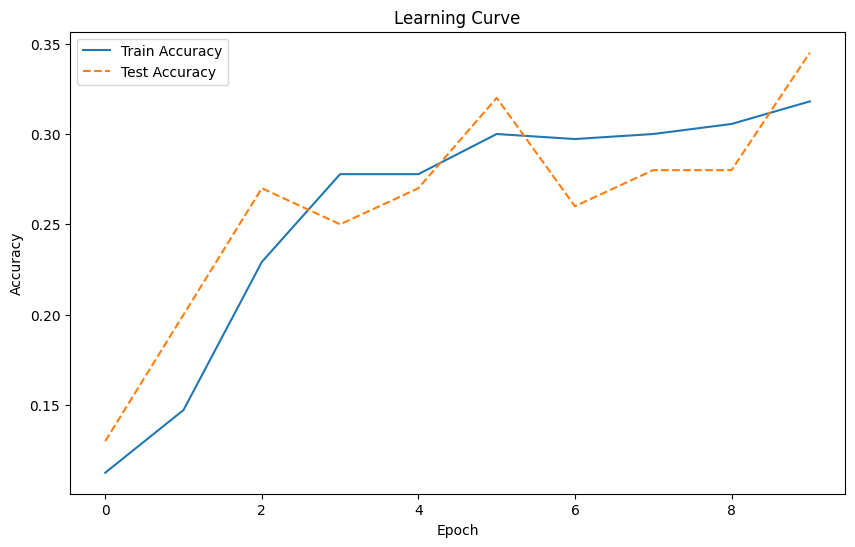

In [37]:
# Assuming x_train_sc has shape (number_of_samples, number_of_features)
# Make sure to replace 'number_of_features' with the actual number of features in your data.

# Define the model
model = Sequential()
# Add hidden layer
model.add(Dense(units=128, input_dim=x_train_sc.shape[1], activation='tanh'))
# Add hidden layer
model.add(Dense(units=64, activation='relu'))
# Add hidden layer
model.add(Dense(units=32, activation='relu'))
# Add hidden layer
model.add(Dense(units=16, activation='relu'))
# Add hidden layer
model.add(Dense(units=8, activation='relu'))
# Output layer
model.add(Dense(units=len(y_train.unique()), activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
# model.summary()
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
# model.summary()


# Custom callback for logging test accuracy at each epoch
class TestAccuracyLogger(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        _, test_accuracy = self.model.evaluate(self.test_data[0], self.test_data[1], verbose=0)
        self.test_accuracies.append(test_accuracy)
        print(f'Test Accuracy after Epoch {epoch + 1}: {test_accuracy * 100:.2f}%')

# Assuming x_test_sc and y_test are your test data and labels
# Also, replace 'num_classes' with the actual number of classes in your classification task.

# Create an instance of the custom callback
test_accuracy_logger = TestAccuracyLogger(test_data=(x_test_sc, y_test_encoded))

# Fit the model with the custom callback
history = model.fit(x_train_sc, y_encoded, epochs=250, batch_size=32, validation_split=0.1, callbacks=[test_accuracy_logger])

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(test_accuracy_logger.test_accuracies, label='Test Accuracy', linestyle='dashed')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# # Fit the model
# # print(x_train_sc)
# model.fit(x_train_sc, y_encoded, epochs=100, batch_size=32, validation_split=0.1)

# # # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(x_test_sc, y_test_encoded)
# print("Test Accuracy: %.2f%%" % (test_accuracy * 100))


In [36]:
print(x_train_sc.shape[0])

800
